In [1]:
import tkinter as tk
from tkinter import filedialog, Label, Canvas, Scrollbar
from PIL import Image, ImageTk, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [2]:
class ImageInterface:
    def __init__(self, master):
        self.master = master
        self.master.title("Image Viewer")

        # Create a Canvas widget with a Scrollbar
        self.canvas = Canvas(self.master)
        self.canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        self.scrollbar = Scrollbar(self.master, orient=tk.VERTICAL, command=self.canvas.yview)
        self.scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

        self.canvas.configure(yscrollcommand=self.scrollbar.set)

        # Create a frame inside the canvas to hold the widgets
        self.frame = tk.Frame(self.canvas)
        self.canvas.create_window((0, 0), window=self.frame, anchor=tk.NW)

        # Bind the canvas to the frame
        self.frame.bind("<Configure>", self.on_frame_configure)

        self.load_button = tk.Button(self.frame, text="Load Image", command=self.load_image)
        self.load_button.pack(pady=10)

        self.image_label = None
        self.image = None
        self.fig = None
        self.ax = None
        self.canvas_widget = None

    def on_frame_configure(self, event):
        self.canvas.configure(scrollregion=self.canvas.bbox("all"))

    def load_image(self):
        filename = filedialog.askopenfilename(filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])
        if filename:
            self.image = Image.open(filename).convert('L')  # Convert to grayscale
            if self.white_represents_zero_intensity():
                self.image = ImageOps.invert(self.image)
            self.render_image()
            self.display_image()

    def white_represents_zero_intensity(self):
        img_array = np.array(self.image)
        return np.any(np.all(img_array == 255, axis=-1))

    def render_image(self):
        if self.image:
            # Resize the image to reduce the number of points in the plot
            resized_image = self.image.resize((400, 300))
            img_array = np.array(resized_image)
            height, width = img_array.shape
            x = np.arange(width)
            y = np.arange(height)
            xv, yv = np.meshgrid(x, y)

            if self.fig is None:
                self.fig = plt.figure()
                self.ax = self.fig.add_subplot(111, projection='3d')
            else:
                self.ax.clear()

            # Downsample the image by taking every nth pixel
            stride = 4 # Adjust this value to change the density of points in the plot
            img_array_downsampled = img_array[::stride, ::stride]
            xv_downsampled, yv_downsampled = np.meshgrid(x[::stride], y[::stride])

            # Map intensities to a uniform range (0 to 1)
            img_array_downsampled = img_array_downsampled / 255.0
            
            self.ax.plot_surface(xv_downsampled, yv_downsampled, img_array_downsampled, cmap='gray', rstride=1, cstride=1)

            self.ax.set_xlabel('X')
            self.ax.set_ylabel('Y')
            self.ax.set_zlabel('Pixel Intensity')

            if self.canvas_widget:
                self.canvas_widget.get_tk_widget().destroy()

            self.canvas_widget = FigureCanvasTkAgg(self.fig, master=self.frame)
            self.canvas_widget.draw()
            self.canvas_widget.get_tk_widget().pack()

    def display_image(self):
        if self.image:
            # Increase the size of the displayed image drastically
            tk_image = ImageTk.PhotoImage(self.image.resize((800, 600)))
            if self.image_label:
                self.image_label.config(image=tk_image)
                self.image_label.image = tk_image
            else:
                self.image_label = Label(self.frame, image=tk_image)
                self.image_label.pack()

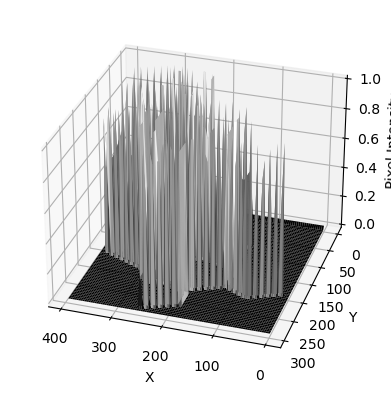

In [3]:
def main():
    root = tk.Tk()
    app = ImageInterface(root)
    root.mainloop()

if __name__ == "__main__":
    main()